In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import keras_tuner
from kerastuner.tuners import RandomSearch
import numpy as np
import math
import pickle

C:\Users\Ananya\AppData\Local\Temp\ipykernel_1872\1930575132.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [23]:
! pip show tensorflow
! pip install --upgrade tensorflow


Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\Ananya\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: tensorflow-intel
Required-by: tf_keras


In [95]:
#loading the data
import pandas as pd


filepath = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\One_Direction_cleaned_lyrics.parquet"
lyrics_df = pd.read_parquet(filepath)


print(lyrics_df.head())


                                        Lyrics_clean
0              you are insecure do not know what for
1  you are turnin' heads when you walk through th...
2                 do not need makeup to cover up huh
3               bein' the way that you are is enough
4               everyone else in the room can see it


In [96]:
# preprocessing the data
tokenizer_lyric = Tokenizer()
tokenizer_lyric.fit_on_texts(lyrics_df['Lyrics_clean'])
sequences = tokenizer_lyric.texts_to_sequences(lyrics_df['Lyrics_clean'])
size_vocab = len(tokenizer_lyric.word_index) + 1


In [97]:
# Creating the sequences

seq_len = 10 # sequence length
input_seq = [] # input sequences
for seq in sequences:
    for i in range(seq_len, len(seq)):
        in_seq = seq[i-seq_len: i+1]
        input_seq.append(in_seq)

input_seq = pad_sequences(input_seq, maxlen=(seq_len+1), padding='pre')
X, y = input_seq[:, :-1], input_seq[:, -1]
y = to_categorical(y,num_classes=size_vocab)



In [98]:
#defining a function to create models

def create__model(embedding_dim, lstm_units, dropout_rate, learning_rate, input_length):
    #  defining the input tensor:
    inputs = Input(shape=(input_length,))
    
    # defining the Embedding layer without the input_length in the constructor:
    x = Embedding(input_dim=size_vocab, output_dim=embedding_dim)(inputs)
    
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units)(x)
    outputs = Dense(size_vocab, activation='softmax')(x)
    
    # Creating and compiling the model:
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model







In [99]:
# model creation

models = []

config_mod = [
    (50, 100, 0.1, 0.001, seq_len),
    (100, 150, 0.2, 0.001, seq_len),
    (150, 200, 0.2, 0.0001, seq_len),
    (100, 100, 0.3, 0.001, seq_len),
    (50, 200, 0.1, 0.01, seq_len)]


In [100]:
# Training and evaluating the models

results = []

hist_list = [] 

for config in config_mod:
    try:
        model = create__model(*config)
        history = model.fit(X,y, epochs= 30, batch_size = 128, validation_split= 0.2, verbose = 2)
        hist_list.append(history)
        models.append(model)
        loss, accuracy = model.evaluate(X,y, verbose=0)
        perplexity = math.exp(loss) if loss <300 else float('inf')
        results.append((model, accuracy, perplexity, loss))
    except Exception as e:
        print(f"An error occurred with configuration {config}: {e}")



Epoch 1/30
11/11 - 5s - loss: 7.3291 - accuracy: 0.0360 - val_loss: 7.3053 - val_accuracy: 0.0180 - 5s/epoch - 418ms/step
Epoch 2/30
11/11 - 1s - loss: 6.9946 - accuracy: 0.0428 - val_loss: 6.5781 - val_accuracy: 0.0180 - 559ms/epoch - 51ms/step
Epoch 3/30
11/11 - 1s - loss: 5.5714 - accuracy: 0.0428 - val_loss: 6.3952 - val_accuracy: 0.0180 - 580ms/epoch - 53ms/step
Epoch 4/30
11/11 - 1s - loss: 5.1613 - accuracy: 0.0428 - val_loss: 6.6075 - val_accuracy: 0.0240 - 707ms/epoch - 64ms/step
Epoch 5/30
11/11 - 1s - loss: 5.1214 - accuracy: 0.0458 - val_loss: 6.7022 - val_accuracy: 0.0240 - 693ms/epoch - 63ms/step
Epoch 6/30
11/11 - 1s - loss: 5.0989 - accuracy: 0.0405 - val_loss: 6.7521 - val_accuracy: 0.0240 - 684ms/epoch - 62ms/step
Epoch 7/30
11/11 - 1s - loss: 5.0877 - accuracy: 0.0458 - val_loss: 6.8003 - val_accuracy: 0.0240 - 692ms/epoch - 63ms/step
Epoch 8/30
11/11 - 1s - loss: 5.0833 - accuracy: 0.0405 - val_loss: 6.8369 - val_accuracy: 0.0180 - 687ms/epoch - 62ms/step
Epoch 9/30

Model 1 - Accuracy: 0.04139172285795212, Perplexity: 242.70635172298103, Loss: 5.491852283477783
Model 2 - Accuracy: 0.04139172285795212, Perplexity: 249.1569690280455, Loss: 5.518083095550537
Model 3 - Accuracy: 0.04139172285795212, Perplexity: 219.61682580352237, Loss: 5.3918843269348145
Model 4 - Accuracy: 0.03779244050383568, Perplexity: 242.18600325706558, Loss: 5.489706039428711
Model 5 - Accuracy: 0.038992200046777725, Perplexity: 238.71702493585767, Loss: 5.475278854370117


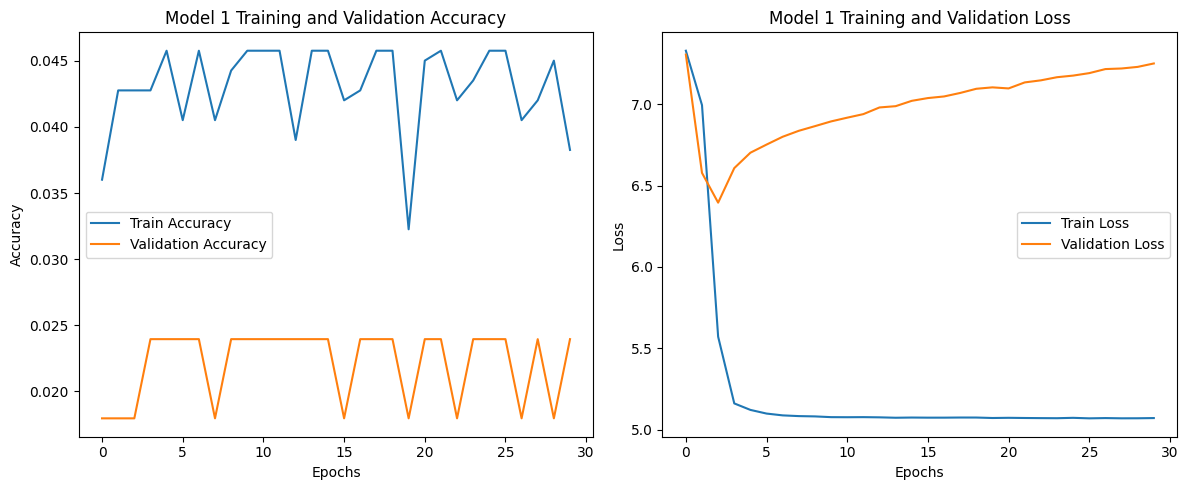

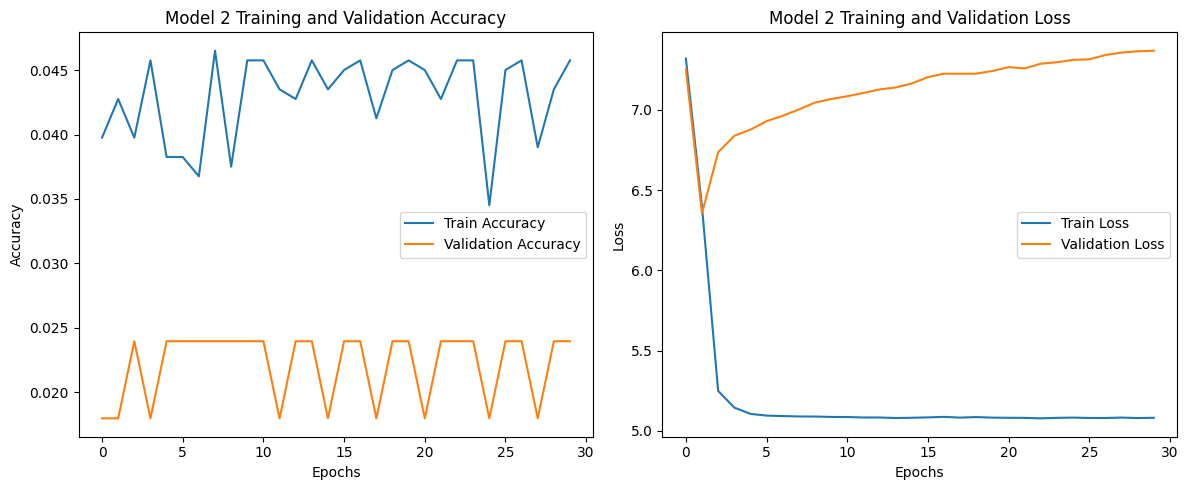

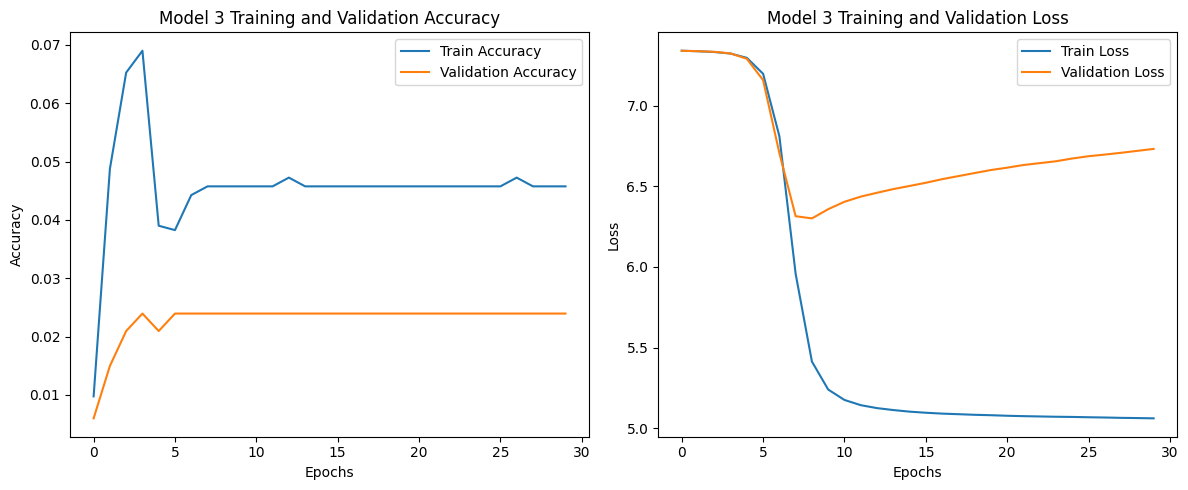

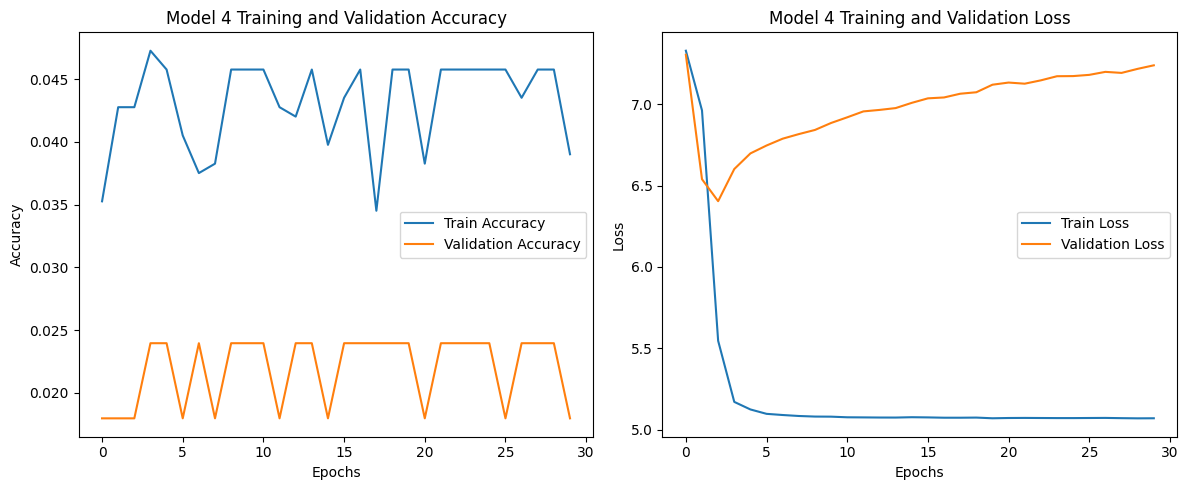

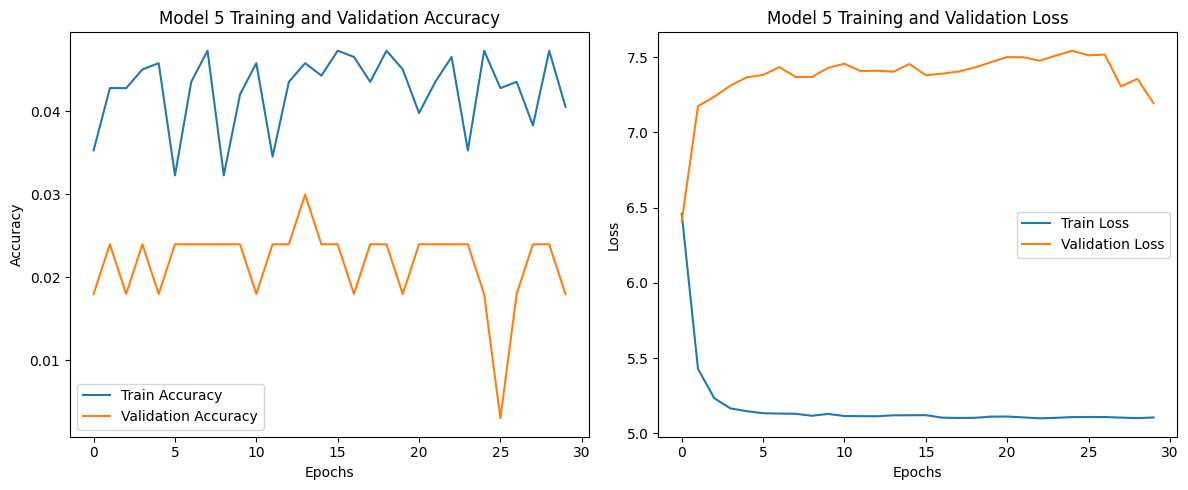

In [101]:
for idx, (model, accuracy, perplexity, loss) in enumerate(results):
    print(f"Model {idx+1} - Accuracy: {accuracy}, Perplexity: {perplexity}, Loss: {loss}")


for idx, history in enumerate(hist_list):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model {idx+1} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model {idx+1} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [102]:
#selecting the best model based on high accuracy and lowest perplexity

best__model = min(results, key = lambda item: (-item[1], item[2])) #negative accuracy for descending order 

best__model[0].save('best_1D_lyrics_generator_model.keras')

# Save the tokenizer using pickle

with open('tokenizer_lyric.pkl', 'wb') as handle:
    pickle.dump(tokenizer_lyric, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [103]:
# defining a function to generate text with controlled word count

def generate__text(seed_text, min_words, max_words, model, tokenizer, max_sequence_len):
    generated_words = seed_text.split()
    while len(generated_words) < max_words:
        token_list = tokenizer.texts_to_sequences([' '.join(generated_words)])[-1]
        # Ensure padding to the exact max_sequence_len that model expects
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = predicted_probs.argmax(axis=-1)[0]
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        generated_words.append(output_word)
        if len(generated_words) >= min_words and (output_word in [".", "!", "?"] or len(generated_words) == max_words):
            break
    return ' '.join(generated_words)

# Example of generating text with the improved function
print(generate__text("love you every single day", 450, 500, best__model[0], tokenizer_lyric, seq_len))




love you every single day you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you yo

In [104]:
def generate__text2(seed_text, min_words, max_words, model, tokenizer, max_sequence_len):
    generated_words = seed_text.split()
    word_freq = {word: generated_words.count(word) for word in generated_words}  # Initialize word frequency dictionary

    while len(generated_words) < max_words:
        token_list = tokenizer.texts_to_sequences([' '.join(generated_words)])[-1]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = predicted_probs.argmax(axis=-1)[0]
        output_word = ""
        
        # Loop to find the next suitable word that hasn't exceeded the repetition limit
        for probability_index in predicted_probs.argsort()[0][::-1]:  # Iterate through indices of sorted probabilities
            potential_word = tokenizer.index_word[probability_index]
            if word_freq.get(potential_word, 0) < 8:
                output_word = potential_word
                word_freq[potential_word] = word_freq.get(potential_word, 0) + 1
                break

        # If no suitable word found, default to the most probable word
        if output_word == "":
            output_word = tokenizer.index_word[predicted_index]
            word_freq[output_word] = word_freq.get(output_word, 0) + 1

        generated_words.append(output_word)

        # Check if generated enough words and try to end on a punctuation if possible
        if len(generated_words) >= min_words and output_word in [".", "!", "?"]:
            break

    return ' '.join(generated_words[:max_words])

# Example of generating text with the improved function
print(generate__text2("saw you for the first time", 450, 500, best__model[0], tokenizer_lyric, seq_len))


saw you for the first time you you you you you you you yeah yeah yeah yeah yeah yeah yeah yeah it it it it it it it it i i i i i i i i me me me me me me me me oh oh oh oh oh oh oh oh the the the the the the the know know know know know know know know to to to to to to to to my my my my my my my my not not not not not not not not is is is is is is is is do do do do do do do do be be be be be be be be go go go go go go go go all all all all all all all all are are are are are are are are up up up up up up up up with with with with with with with with love love love love love love love love your your your your your your your your ooh ooh ooh ooh ooh ooh ooh ooh never never never never never never never never like like like like tonight tonight tonight tonight tonight tonight tonight tonight like like like like heart heart heart heart heart heart heart am am am am am am am am heart of of of of of of of of in in in in in in in in about about about about about about about about a a a a a a a

In [13]:
! pip install transformers


# Lyrics generation another model


In [105]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import re

# Checking the GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [106]:
#loading the vocabulary from a text 

def load_vocab(file_path):
    with open(file_path, 'r') as file:
        vocab_words = file.read().splitlines()
    return set(vocab_words)

#loading and preparing the lyrics

def loading_lyrics(file_path2):
    lyrics_df2 = pd.read_parquet(file_path2)
    return ' '.join(lyrics_df2['Lyrics_clean'].values)


In [107]:
#filtering lyrics based on the vocab set

def lyrics_filter(lyrics, vocab_set):
    filtered = ' '.join([word if word.lower() in vocab_set else '' for word in re.findall(r'\b\w+\b', lyrics)])
    return re.sub(r'\s+', ' ', filtered).strip()


# Lyrics Dataset
class LyricsDataset(Dataset):
    def __init__(self, text, seq_length):
        chars = sorted(list(set(text)))
        self.char_to_int = {ch: i for i, ch in enumerate(chars)}
        self.int_to_char = {i: ch for i, ch in enumerate(chars)}
        self.data = [self.char_to_int[ch] for ch in text]
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        return (torch.tensor(self.data[index:index+self.seq_length]),
                torch.tensor(self.data[index+1:index+self.seq_length+1]))
    

In [108]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, states):
        x = self.embedding(x)
        x, states = self.lstm(x, states)
        x = self.fc(x)
        return x, states

    def init_states(self, batch_size):
        # Adjust the state initialization to the current batch size
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda(),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda())
    

In [109]:
def train_model_plot(model, data_loader, epochs, criterion, optimizer, vocab_size, model_path):
    model.train()
    epoch_losses = []  # to store loss per epoch for plots

    for epoch in range(epochs):
        batch_losses = []  # to store loss per batch for this epoch

        # Note: No need to initialize states here, we'll do it per batch

        for batch, (x, y) in enumerate(data_loader):
            # Initialize states specifically for the current batch size
            state_h, state_c = model.init_states(x.size(0))  # Adjust state dimensions based on the batch size

            optimizer.zero_grad()
            x, y = x.cuda(), y.cuda()
            y_pred, (state_h, state_c) = model(x, (state_h.detach(), state_c.detach()))  # detach states to prevent backprop through them
            loss = criterion(y_pred.transpose(1, 2), y)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        # Average loss for this epoch
        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

    # After training, plot the loss per epoch
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_losses, label='Training Loss')
    plt.title('Training Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Saving the model state
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

    

In [110]:
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.cuda(), y.cuda()
            outputs, _ = model(x, model.init_states(x.size(0)))
            loss = criterion(outputs.transpose(1, 2), y)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 2)
            correct += (predicted == y).sum().item()
            total += y.numel()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def train_model_plot(model, train_loader, val_loader, epochs, criterion, optimizer, model_path):
    model.train()
    epoch_losses = []  # to store loss per epoch for plots
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        batch_losses = []  # to store loss per batch for this epoch
        model.train()

        for batch, (x, y) in enumerate(train_loader):
            state_h, state_c = model.init_states(x.size(0))  # Adjust state dimensions based on the batch size
            optimizer.zero_grad()
            x, y = x.cuda(), y.cuda()
            y_pred, (state_h, state_c) = model(x, (state_h.detach(), state_c.detach()))
            loss = criterion(y_pred.transpose(1, 2), y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        # Average loss for this epoch
        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Plotting the training and validation losses and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='r')
    plt.title('Validation Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    # Saving the model state
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

In [111]:
# function to generate lyrics

def generate_lyrics(model, start_str, int_to_char, char_to_int, length, temperature=1.0):
    model.eval()
    states = model.init_states(1)
    input = torch.tensor([[char_to_int[ch] for ch in start_str]]).cuda()
    text = start_str

    for _ in range(length):
        output, states = model(input, states)
        output = output.squeeze().div(temperature).exp()
        char_id = torch.multinomial(output, 1)[-1,0].item()
        char = int_to_char[char_id]
        text += char
        input = torch.tensor([[char_id]]).cuda()
    return text

#saving the lyrics to a file

def save_lyrics(lyrics, filename):
    with open(filename, 'w') as file:
        file.write(lyrics)



In [112]:
def generate_lyrics(model, start_str, int_to_char, char_to_int, length):
    model.eval()
    states = model.init_states(1)
    input_indices = []

    # Convert start string to lowercase to match training data
    start_str = start_str.lower()

    # Convert characters to indices safely
    for ch in start_str:
        if ch in char_to_int:
            input_indices.append(char_to_int[ch])
        else:
            print(f'Character "{ch}" not in dictionary, skipping.')
            continue  # Or handle unknown character

    if not input_indices:
        print("No valid characters to process.")
        return ""

    input_tensor = torch.tensor([input_indices]).cuda()
    text = start_str

    for _ in range(length):
        output, states = model(input_tensor, states)
        output = output[:, -1, :]  # Get the last time step
        probabilities = torch.softmax(output, dim=1)
        char_id = torch.multinomial(probabilities, 1).item()
        char = int_to_char[char_id]
        text += char
        input_tensor = torch.tensor([[char_id]]).cuda()

    return text



In [113]:
# paths to files

vocab_path = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\The_Oxford_3000.txt"
lyrics_path = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\One_Direction_cleaned_lyrics.parquet"
model_save_path = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\lstm_model_lyrics.pth"


In [114]:
# loading vocab and lyrics

vocab_set = load_vocab(vocab_path)
all_lyrics = loading_lyrics(lyrics_path)
all_lyrics_filt = lyrics_filter(all_lyrics, vocab_set)


In [115]:
# Dataset and DataLoader
seq_length = 100
batch_size = 64
dataset = LyricsDataset(all_lyrics_filt, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)



In [116]:
from torch.utils.data import DataLoader, random_split


total_samples = len(dataset)
val_size = int(0.1 * total_samples)  # Let's say 10% of the data for validation
train_size = total_samples - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Now create DataLoaders for both datasets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [117]:

# For Model, Loss, and Optimizer


vocab_size = len(dataset.char_to_int)
embedding_dim = 256
hidden_dim = 512
num_layers = 2
epochs = 30
learning_rate = 0.001


In [118]:
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Epoch 1/30, Train Loss: 0.5659, Val Loss: 0.1431, Val Acc: 0.9559
Epoch 2/30, Train Loss: 0.1285, Val Loss: 0.1241, Val Acc: 0.9596
Epoch 3/30, Train Loss: 0.1167, Val Loss: 0.1193, Val Acc: 0.9603
Epoch 4/30, Train Loss: 0.1113, Val Loss: 0.1150, Val Acc: 0.9615
Epoch 5/30, Train Loss: 0.1082, Val Loss: 0.1130, Val Acc: 0.9621
Epoch 6/30, Train Loss: 0.1058, Val Loss: 0.1120, Val Acc: 0.9622
Epoch 7/30, Train Loss: 0.1042, Val Loss: 0.1115, Val Acc: 0.9622
Epoch 8/30, Train Loss: 0.1027, Val Loss: 0.1105, Val Acc: 0.9627
Epoch 9/30, Train Loss: 0.1017, Val Loss: 0.1095, Val Acc: 0.9627
Epoch 10/30, Train Loss: 0.1007, Val Loss: 0.1088, Val Acc: 0.9629
Epoch 11/30, Train Loss: 0.0999, Val Loss: 0.1082, Val Acc: 0.9629
Epoch 12/30, Train Loss: 0.0993, Val Loss: 0.1082, Val Acc: 0.9631
Epoch 13/30, Train Loss: 0.0987, Val Loss: 0.1075, Val Acc: 0.9632
Epoch 14/30, Train Loss: 0.0984, Val Loss: 0.1075, Val Acc: 0.9632
Epoch 15/30, Train Loss: 0.0978, Val Loss: 0.1070, Val Acc: 0.9631
Epoc

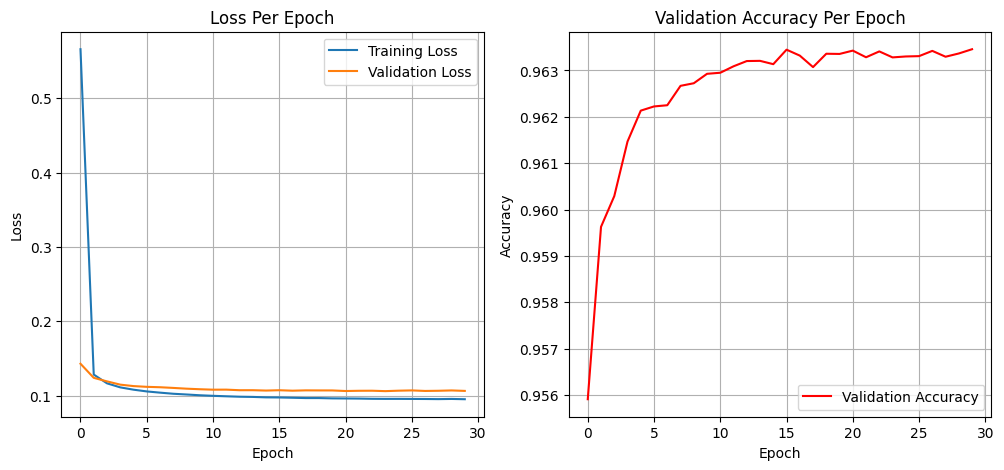

Model saved to C:\Users\Ananya\anaconda3\Dissertation - UL\Music-Generation-with-AI-1\Project\lstm_model_lyrics.pth


In [119]:
# Train the model and plot loss
train_model_plot(model, train_dataloader, val_dataloader, epochs, criterion, optimizer, model_save_path)


In [120]:
# Generate new lyrics
start_str = "when I first saw you"

generated_lyrics = generate_lyrics(model, start_str, dataset.int_to_char, dataset.char_to_int, 400)
print(generated_lyrics)

when i first saw you call me when you lonely when you cannot sleep will be your temporary fix you control me even if it just tonight yeah yeah yeah you call me when you feel like your good time will be your temporary fix you control me even if it just tonight yeah yeah yeah you call me when you feel like your good time will be your temporary fix you control me even if it just tonight yeah yeah yeah you call me when y


In [121]:
def generate_and_distribute_lyrics(model, start_str, int_to_char, char_to_int, total_length):
    # Generate extended lyrics from the model
    extended_lyrics = generate_lyrics(model, start_str, int_to_char, char_to_int, total_length)
    
    # Split the generated lyrics into words
    words = extended_lyrics.split()
    
    # Names of the artists
    names = ["Harry", "Niall", "Louis", "Zayn", "Liam"]
    np.random.shuffle(names)  # Shuffle to randomize the order each time

    # Calculate roughly equal parts for each name, but it can vary as total_length is not always a multiple of 5
    part_length = len(words) // len(names)
    parts = [words[i * part_length:(i + 1) * part_length] for i in range(len(names))]
    
    # Handle the last few words that may have been left out due to integer division
    leftover = len(words) % len(names)
    if leftover:
        parts[-1].extend(words[-part_length - leftover:])

    # Assign each part to a name and format it
    lyrics_with_names = []
    for name, part in zip(names, parts):
        part_text = ' '.join(part)
        lyrics_with_names.append(f"{name}: {part_text}")

    return "\n\n".join(lyrics_with_names)

# sample usage within  main function or another appropriate section of your code

    # Assuming model and other components are already initialized and loaded appropriately
user_input = input("Enter the starting words of the song: ")
final_lyrics = generate_and_distribute_lyrics(model, user_input, dataset.int_to_char, dataset.char_to_int, 1000)
print(final_lyrics)


Liam: saw you in a blue dress the light in her there no no there no question she not in with no way out and long way down everybody someone around but cannot hold you too now through the wire through the wire what

Harry: feeling to be right here beside you now you in my arms when the air out and we both running wild the sky down but you have they in your and have something missing tonight what feeling to be king beside you somehow

Niall: wish could be the teal that you like with your other see it but not that it there something about your laugh that it me want to have to there nothing funny so we laugh at every like the so let us just

Zayn: take it real slow forget about the clock that to the way that you kiss on me kiss on me and you have always the only one and you to know without you cannot face it all we have fun but they say

Louis: that we too young let them say what they want from the way that we touch baby the way that we touch baby it not me it not you there reason just rea

In [122]:
def generate_and_distribute_lyrics(model, start_str, int_to_char, char_to_int, total_length):
    # Generate extended lyrics from the model
    extended_lyrics = generate_lyrics(model, start_str, int_to_char, char_to_int, total_length)
    
    # Split the generated lyrics into words
    words = extended_lyrics.split()
    
    # Names of the artists in the specified order
    names = ["Harry", "Louis", "Zayn", "Niall", "Liam"]
    
    # Calculate roughly equal parts for each name
    part_length = len(words) // len(names)
    parts = [words[i * part_length:(i + 1) * part_length] for i in range(len(names))]
    
    # Handle the last few words that may have been left out due to integer division
    leftover = len(words) % len(names)
    if leftover:
        parts[-1].extend(words[-part_length - leftover:])

    # Assign each part to a name and format it into paragraphs
    lyrics_with_names = []
    for name, part in zip(names, parts):
        part_text = ' '.join(part)
        formatted_text = f"{name}:\n{part_text}\n\n"
        lyrics_with_names.append(formatted_text)

    return "".join(lyrics_with_names)


   
user_input = input("Enter the starting words of the song: ")
final_lyrics = generate_and_distribute_lyrics(model, user_input, dataset.int_to_char, dataset.char_to_int, 500)
print(final_lyrics)


Harry:
saw you last year in a cafe with me there no right time or place because anyo ever through the oh oh

Louis:
oh yeah yeah yeah how it but know that will not forget her oh oh oh yeah yeah yeah know that will

Zayn:
not forget her because we all night to the best song ever think it oh oh oh think it yeah yeah yeah

Niall:
think it her name and her dentist dirty mouth dirty mouth but she me like she it take you home with me

Liam:
we every line now cannot remember how it but know you know know you know will remember you and know you know we every line now cannot remember how it but know you know know you know will remember you and know you know hope you will re




In [ ]:
wors = 1000


Harry:
when i first saw you, from the start the start like this with tight yeah then my kiss your tonight 
pray that you will see the light that from the above and say cause love you more than this yeah when he his

Louis: 
arms and you tonight you tonight cause love you more than this yeah yeah 
when he you down might just die inside broken shut the door turn the light off be with you 
feel your love lay beside you cannot hide this even

Zayn: 
though try heart time me touch skin it this and the stream down my face if we could only have this life for one more day 
if we could only turn back time you know be your life your voice your reason to

Niall: 
be my love my heart breathing for this breathing for this moment in time find the to say to say before you 
leave me today yeah he your hand die little watch your and in why you look at me like that when

Liam: 
you walk by try to say it but then freeze and never it my tongue the get hear the beat of my heart
whenever near you but see you with him slow me apart cause you see whenever you kiss him oh how
